# Learning Z/nZ x Z/nZ group actions
This notebook is adapted from the `modular arithmetic` notebook, replacing `Z/nZ` group action with `Z/nZ x Z/nZ` group action 

In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

## Architecture

In [71]:
class TwoLayerNet(nn.Module):
    def __init__(self, p, hidden_size, nonlinearity='square', init_scale=1.0, output_scale=1.0):
        super(TwoLayerNet, self).__init__()
        
        # Store dimensions
        self.p = p
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.init_scale = init_scale
        self.output_scale = output_scale
        self.group_size = p * p  # Since input is flattened p x p matrix
        
        # Initialize parameters 
        self.U = nn.Parameter(self.init_scale * torch.randn(hidden_size, self.group_size) / np.sqrt(2 * self.group_size))  # First p elements
        self.V = nn.Parameter(self.init_scale * torch.randn(hidden_size, self.group_size) / np.sqrt(2 * self.group_size))  # Second p elements
        self.W = nn.Parameter(self.init_scale * torch.randn(hidden_size, self.group_size) / np.sqrt(self.group_size)) # Second layer weights

    def forward(self, x):
        # First layer (linear and combined)
        x1 = x[:, :self.group_size] @ self.U.T
        x2 = x[:, self.group_size:] @ self.V.T
        x_combined = x1 + x2

        # Apply nonlinearity activation
        if self.nonlinearity == 'relu':
            x_combined = torch.relu(x_combined)
        elif self.nonlinearity == 'square':
            x_combined = x_combined**2
        elif self.nonlinearity == 'linear':
            x_combined = x_combined
        elif self.nonlinearity == 'tanh':
            x_combined = torch.tanh(x_combined)
        elif self.nonlinearity == 'gelu':
            gelu = torch.nn.GELU()
            x_combined = gelu(x_combined)
        else:
            raise ValueError(f"Invalid nonlinearity '{self.nonlinearity}' provided.")

        # Second layer (linear)
        x_out = x_combined @ self.W

        # Feature learning scaling
        x_out *= self.output_scale

        return x_out

## Optimization

In [72]:
def test_accuracy(model, dataloader):
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the largest value (class)
            _, true_labels = torch.max(labels, 1)  # Get the true class from the one-hot encoding
            correct += (predicted == true_labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    return accuracy

def train(model, dataloader, criterion, optimizer, epochs=100, verbose_interval=1):
    model.train()  # Set the model to training mode
    loss_history = []  # List to store loss values
    accuracy_history = []
    param_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            # Check if labels are all zeros or if labels are not being set correctly
            if torch.all(labels == 0):
                print(f"Warning: All labels are zero in batch {batch_idx} of epoch {epoch}")
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                print(f"NaN detected in inputs or labels in batch {batch_idx} of epoch {epoch}")

            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers

            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass

            # Check if outputs are all zeros or constant
            if torch.all(outputs == 0):
                print(f"Warning: Model outputs are all zero in batch {batch_idx} of epoch {epoch}")

            loss = criterion(outputs, labels)  # Compute loss

            # Check if loss is zero from the start
            if epoch == 0 and batch_idx == 0 and loss.item() == 0.0:
                print("Warning: Loss is zero at the very first batch. Check if criterion and labels are set up correctly.")

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        # Append the average loss for the epoch to loss_history
        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)

        # Append the accuracy
        model.eval()
        accuracy = test_accuracy(model, dataloader)
        accuracy_history.append(accuracy)
        model.train()

        # Save current model parameters
        current_params = {
            "U": model.U.detach().cpu().clone(),
            "V": model.V.detach().cpu().clone(),
            "W": model.W.detach().cpu().clone()
        }
        param_history.append(current_params)

        # Print verbose information every `verbose_interval` epochs
        if (epoch + 1) % verbose_interval == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Plot results every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')
            model.eval()
            with torch.no_grad():
                # Get one random example from the dataset
                idx = np.random.randint(len(dataloader.dataset))
                x, y = dataloader.dataset[idx]
                # If x is not already a tensor, convert it
                if not torch.is_tensor(x):
                    x = torch.tensor(x, dtype=torch.float32)
                if not torch.is_tensor(y):
                    y = torch.tensor(y, dtype=torch.float32)
                # Move to device if needed
                x_input = x.view(1, -1)
                if hasattr(model, 'device'):
                    x_input = x_input.to(model.device)
                elif next(model.parameters()).is_cuda:
                    x_input = x_input.cuda()
                output = model(x_input)
                output_np = output.cpu().numpy().squeeze()
                target_np = y.cpu().numpy().squeeze() if hasattr(y, 'cpu') else y.numpy().squeeze()

                # Try to infer image size if possible
                # Ensure x, output, and target are on CPU and numpy arrays for plotting
                if torch.is_tensor(x):
                    x_np = x.detach().cpu().numpy()
                else:
                    x_np = np.array(x)
                if torch.is_tensor(output):
                    output_np = output.detach().cpu().numpy().squeeze()
                # output_np already defined above, but ensure it's on CPU and numpy
                if torch.is_tensor(y):
                    target_np = y.detach().cpu().numpy().squeeze()
                else:
                    target_np = np.array(y).squeeze()

                # Infer image size
                image_size = int(np.sqrt(x_np.shape[-1] // 2)) if x_np.shape[-1] % 2 == 0 else int(np.sqrt(x_np.shape[-1]))

                fig, axs = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
                axs[0].imshow(x_np[:image_size*image_size].reshape(image_size, image_size))
                axs[0].set_title('Input 1')
                axs[1].imshow(x_np[image_size*image_size:].reshape(image_size, image_size))
                axs[1].set_title('Input 2')
                axs[2].imshow(output_np.reshape(image_size, image_size))
                axs[2].set_title('Output')
                axs[3].imshow(target_np.reshape(image_size, image_size))
                axs[3].set_title('Target')
                plt.tight_layout()
                plt.show()
             

    return loss_history, accuracy_history, param_history # Return loss history for plotting

## Plotting functions

In [73]:
def style_axes(ax, numyticks=5, numxticks=5, labelsize=24):
    # Y-axis ticks
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=numyticks))
    
    # X-axis ticks
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=numxticks))

    # Scientific notation formatting
    if ax.get_yscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
    if ax.get_xscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    # Customize spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

In [74]:
def get_power_2d(points):
    """
    Compute the 2D power spectrum of a real-valued array.

    Parameters
    ----------
    points : ndarray (M, N)
        Real-valued 2D input array.

    Returns
    -------
    freqs_u : ndarray (M,)
        Frequency bins for the first axis (rows).
    freqs_v : ndarray (N//2 + 1,)
        Frequency bins for the second axis (columns).
    power : ndarray (M, N//2 + 1)
        Power spectrum of the input.
    """
    M, N = points.shape
    num_coefficients = N // 2 + 1
    
    # Perform 2D rFFT
    ft = np.fft.rfft2(points)
    
    # Power spectrum normalized by total number of samples
    power = np.abs(ft)**2 / (M * N)
    
    # Double non-redundant frequencies along last axis (like in 1D)
    if N % 2 == 0:  # N even → Nyquist frequency included
        power[:, 1:num_coefficients - 1] *= 2
        # power[1:num_coefficients - 1, :] *= 2

    else:  # N odd → no Nyquist frequency
        power[:, 1:] *= 2
        # power[1:, :] *= 2

    # Check Parseval’s theorem
    total_power = np.sum(power)
    norm_squared = np.linalg.norm(points)**2
    if not np.isclose(total_power, norm_squared, rtol=1e-3):
        print(f"Warning: Total power {total_power:.3f} does not match norm squared {norm_squared:.3f}")

    # Frequency bins
    freqs_u = np.fft.fftfreq(M)          # full symmetric frequencies (rows)
    freqs_v = np.fft.rfftfreq(N)         # only non-negative frequencies (columns)

    return freqs_u, freqs_v, power


def plot2D(ax, points, color, continuous, alpha=1.0):
    # Adapted: points is a flattened square matrix. Un-flatten and plot as 2D signal.
    n = int(np.sqrt(len(points)))
    if n * n != len(points):
        raise ValueError("Length of points is not a perfect square, cannot reshape to square matrix.")
    mat = np.array(points).reshape((n, n))
    im = ax.imshow(mat, cmap='viridis', interpolation='nearest', alpha=alpha)
    # Optionally add a colorbar if desired:
    # plt.colorbar(im, ax=ax)

## Template and Dataset Functions

In [80]:
def one_hot2D(p):
    """One-hot encode an integer value in R^pxp.
    
    Parameters
    ----------
    p : int
        p in Z/pZ x Z/pZ. Number of elements in the 2D modular addition
    
    Returns
    -------
    mat : np.ndarray
        A flattened one-hot encoded matrix of shape (p*p).
    """
    mat = np.zeros((p,p))
    mat[0,0] = 1
    mat = mat.flatten()
    return mat

def generate_fixed_template(p):
    """Generate a fixed template for the 2D modular addition dataset.

    Note: Since our input is a flattened matrix, we should un-flatten
    the weights vectors to match the shape of the template when we visualize.
    
    Parameters
    ----------
    p : int
        p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition

    Returns
    -------
    template : np.ndarray
        A flattened 2D array of shape (p, p) representing the template.
        After flattening, it will have shape (p*p,).
    """
    # Generate template array from Fourier spectrum
    spectrum = np.zeros((p,p), dtype=complex)

    # Three low-frequency bins with Gaussian-ish weights
    v1 = 2.0
    v2 = 1.3 #0.1 # make sure this is not too close to v1
    v3 = 1 #0.01

    # Mode (1,2)
    spectrum[1,0] = v1
    spectrum[-1,0] = np.conj(v1) 

    # Mode (2,1)
    spectrum[0,1] = v2
    spectrum[0,-1] = np.conj(v2)

    # Mode (1,1)
    spectrum[1,1] = v3
    spectrum[-1,-1] = np.conj(v3)
    
    # Generate signal from spectrum
    template = np.fft.ifft2(spectrum).real

    template = template.flatten()

    return template

def ModularAdditionDataset2D(p, template, fraction=0.3, random_state=42):
    """Generate a dataset for the 2D modular addition operation.

    General idea: We are generating a dataset where each sample consists of 
    two inputs (a*template and b*template) and an output (a*b)*template,
    where a, b \in Z/pZ x Z/pZ. The template is a flattened 2D array
    representing the modular addition operation in a 2D space.

    Each element X_i will contain the template with a different a_i, b_i, and
    in fact X contains the template at all possible a, b shifts.
    The output Y_i will contain the template shifted by a_i*b_i.
    * refers to the composition of two group actions (but by an abuse of notation, 
    also refers to group action on the template. oops.)
    
    Parameters
    ----------
    p : int
        p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition.
    template : np.ndarray
        A flattened 2D array of shape (p*p,) representing the template.
        This should be generated using `generate_fixed_template(p)`.
        
    Returns
    -------
    X : np.ndarray
        Input data of shape (p^4, 2, p*p). 
        2 inputs (a and b), each with shape (p*p,).
         is the total number of combinations of shifted a's and b's.
    Y : np.ndarray
        Output data of shape (p^4, p*p), where each sample is the result of the modular addition."""
    # Initialize data arrays
    X = np.zeros((p ** 4, 2, p * p))  # Shape: (p^4, 2, p*p)
    Y = np.zeros((p ** 4, p * p))     # Shape: (p^4, p*p)
    translations = np.zeros((p**4, 3, 2), dtype=int)
    
    # Generate the dataset
    idx = 0
    template_2d = template.reshape((p, p))
    for a_x in range(p):
        for a_y in range(p):
            for b_x in range(p):
                for b_y in range(p):
                    q_x = (a_x + b_x) % p
                    q_y = (a_y + b_y) % p
                    X[idx, 0, :] = np.roll(np.roll(template_2d, a_x, axis=0), a_y, axis=1).flatten()
                    X[idx, 1, :] = np.roll(np.roll(template_2d, b_x, axis=0), b_y, axis=1).flatten()
                    Y[idx, :] = np.roll(np.roll(template_2d, q_x, axis=0), q_y, axis=1).flatten()
                    translations[idx, 0, :] = (a_x, a_y)
                    translations[idx, 1, :] = (b_x, b_y)
                    translations[idx, 2, :] = (q_x, q_y)
                    idx += 1

    assert 0 < fraction <= 1.0, "fraction must be in (0, 1]"
    N = X.shape[0]
    n_sample = int(np.ceil(N * fraction))
    rng = np.random.default_rng(random_state)
    indices = rng.choice(N, size=n_sample, replace=False)

    return X[indices], Y[indices], translations[indices]
            

<>:68: SyntaxWarning: invalid escape sequence '\i'
<>:68: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_2344689/3965156574.py:68: SyntaxWarning: invalid escape sequence '\i'
  where a, b \in Z/pZ x Z/pZ. The template is a flattened 2D array


# Define Dataset and Visualize

In [81]:
def plot_template(template, template_minus_mean, indices, p, i=4):
    template_matrix = template.reshape((p, p))
    template_minus_mean_matrix = template_minus_mean.reshape((p, p))
    translation = indices[i]
    print(f"Translation for sample {i}: a=({translation[0][0]}, {translation[0][1]}), b=({translation[1][0]}, {translation[1][1]}), a+b=({translation[2][0]}, {translation[2][1]})")

    Xi_a = X[i, 0].reshape((p, p))
    Xi_b = X[i, 1].reshape((p, p))
    Yi = Y[i].reshape((p, p))

    # Plot the original template and the matrices
    fig, axs = plt.subplots(1, 5, figsize=(16, 4))

    # Plot the original template
    im_template = axs[0].imshow(template_matrix, cmap='viridis')
    axs[0].set_title("Original Template")
    plt.colorbar(im_template, ax=axs[0])

    im_template_minus_mean = axs[1].imshow(template_minus_mean_matrix, cmap='viridis')
    axs[1].set_title("Template Minus Mean")
    plt.colorbar(im_template_minus_mean, ax=axs[1])

    # Extract translation values for titles
    a_x, a_y = translation[0]
    b_x, b_y = translation[1]
    q_x, q_y = translation[2]

    # Plot X[i][0] (a*template)
    im0 = axs[2].imshow(Xi_a, cmap='viridis')
    axs[2].set_title(f"X_a: Δx {a_x} Δy {a_y}")
    axs[2].set_xlabel("y")
    axs[2].set_ylabel("x")
    plt.colorbar(im0, ax=axs[2])

    # Plot X[i][1] (b*template)
    im1 = axs[3].imshow(Xi_b, cmap='viridis')
    axs[3].set_title(f"X_b: Δx {b_x} Δy {b_y}")
    axs[3].set_xlabel("y")
    axs[3].set_ylabel("x")
    plt.colorbar(im1, ax=axs[3])

    # Plot Y[i] ((a+b)*template)
    im2 = axs[4].imshow(Yi, cmap='viridis')
    axs[4].set_title(f"Y: Δx {q_x} Δy {q_y}")
    axs[4].set_xlabel("y")
    axs[4].set_ylabel("x")
    plt.colorbar(im2, ax=axs[4])

    plt.tight_layout()
    plt.show()

Template mean: -4.85722573273506e-19
Translation for sample 4: a=(1, 3), b=(0, 2), a+b=(1, 5)


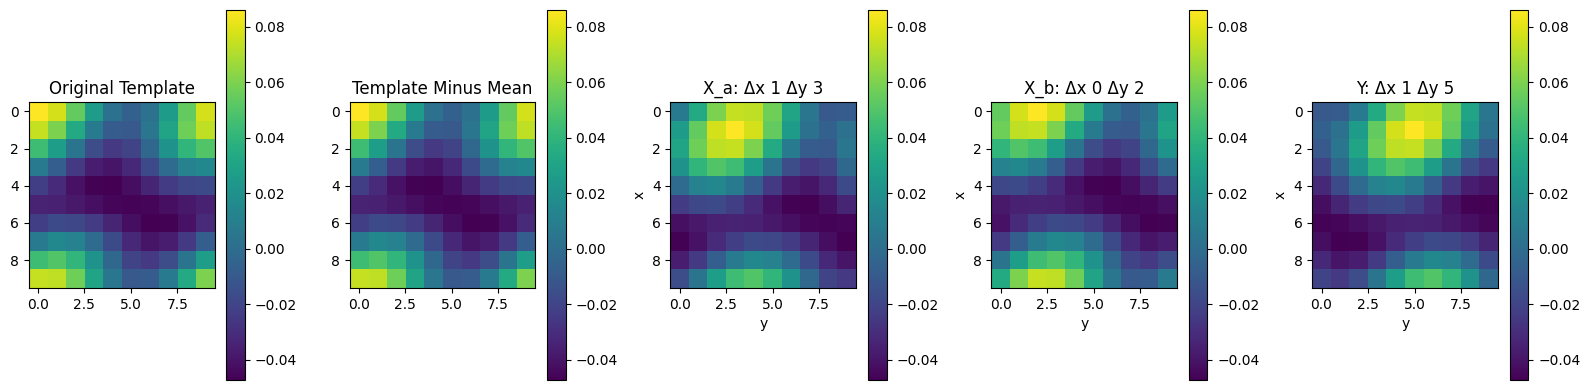

X_tensor shape: torch.Size([10000, 200]), Y_tensor shape: torch.Size([10000, 100])


In [82]:
# Data Generation using the new function
p = 10  # Modulus

# Choose template
# template = generate_template(p, 2, 1.0)
# template = one_hot2D(p)
og_template = generate_fixed_template(p)

print("Template mean:", np.mean(og_template))

# Mean center template
template = og_template - np.mean(og_template) # subtract the zeroth frequency

# Generate dataset using numpy
X, Y, indices = ModularAdditionDataset2D(p, template, fraction=1.0)
plot_template(og_template, template, indices, p, i=4)

# Convert to PyTorch tensors
X_len = X.shape[-1]
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 2 * X_len)  # Flatten input (num_samples, 2*p)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Targets (num_samples, p)
print(f"X_tensor shape: {X_tensor.shape}, Y_tensor shape: {Y_tensor.shape}")

# Move tensors and model to the correct device if not already
X_tensor = X_tensor.to(device)
Y_tensor = Y_tensor.to(device)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

## Gradient Descent Experiment

GPU is available. Using CUDA.
X_tensor device: cuda:0
Y_tensor device: cuda:0
Model device: cuda:0
Epoch 10/1000, Loss: 0.0013, Accuracy: 1.75%
Epoch 20/1000, Loss: 0.0013, Accuracy: 1.87%
Epoch 30/1000, Loss: 0.0013, Accuracy: 1.58%
Epoch 40/1000, Loss: 0.0013, Accuracy: 1.07%
Epoch 50/1000, Loss: 0.0013, Accuracy: 0.91%
Epoch 60/1000, Loss: 0.0013, Accuracy: 2.33%
Epoch 70/1000, Loss: 0.0013, Accuracy: 3.40%
Epoch 80/1000, Loss: 0.0012, Accuracy: 4.20%
Epoch 90/1000, Loss: 0.0009, Accuracy: 4.80%
Epoch 100/1000, Loss: 0.0006, Accuracy: 9.40%
Epoch 100/1000, Loss: 0.000564


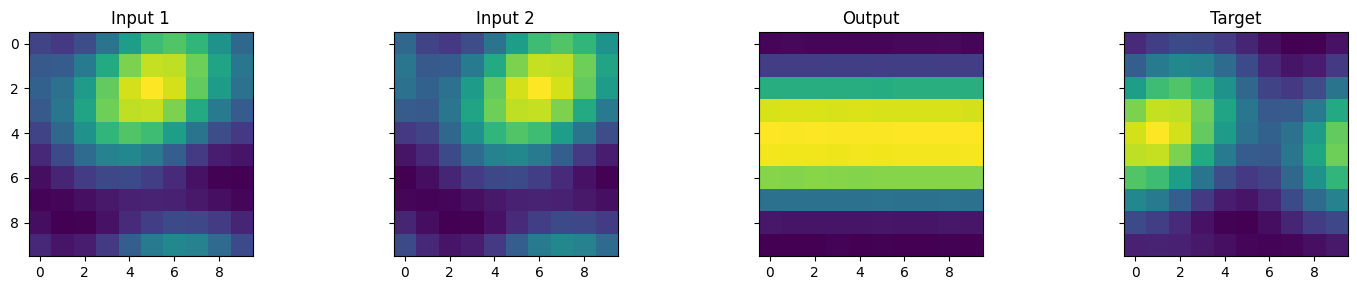

Epoch 110/1000, Loss: 0.0006, Accuracy: 9.99%
Epoch 120/1000, Loss: 0.0005, Accuracy: 10.00%
Epoch 130/1000, Loss: 0.0005, Accuracy: 10.00%
Epoch 140/1000, Loss: 0.0005, Accuracy: 10.01%
Epoch 150/1000, Loss: 0.0005, Accuracy: 10.21%
Epoch 160/1000, Loss: 0.0005, Accuracy: 11.70%
Epoch 170/1000, Loss: 0.0005, Accuracy: 18.03%
Epoch 180/1000, Loss: 0.0005, Accuracy: 19.25%
Epoch 190/1000, Loss: 0.0005, Accuracy: 21.73%
Epoch 200/1000, Loss: 0.0005, Accuracy: 23.17%
Epoch 200/1000, Loss: 0.000462


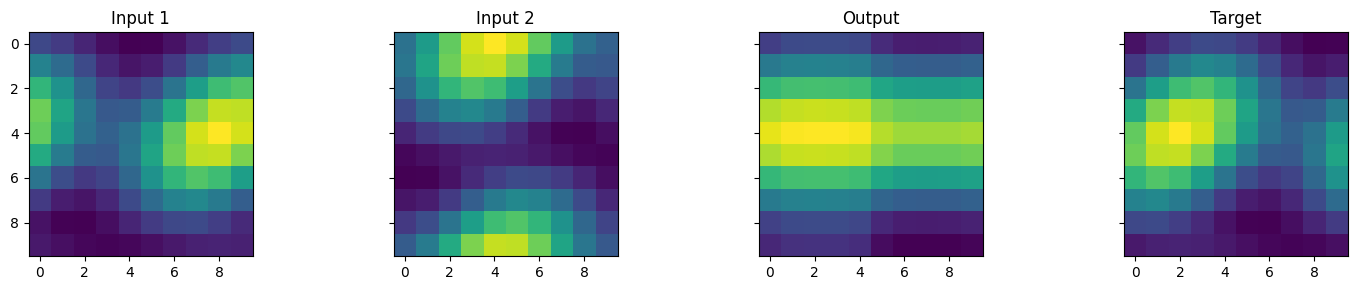

Epoch 210/1000, Loss: 0.0004, Accuracy: 32.59%
Epoch 220/1000, Loss: 0.0003, Accuracy: 50.79%
Epoch 230/1000, Loss: 0.0002, Accuracy: 82.77%
Epoch 240/1000, Loss: 0.0002, Accuracy: 98.31%
Epoch 250/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 260/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 270/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 280/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 290/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 300/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 300/1000, Loss: 0.000200


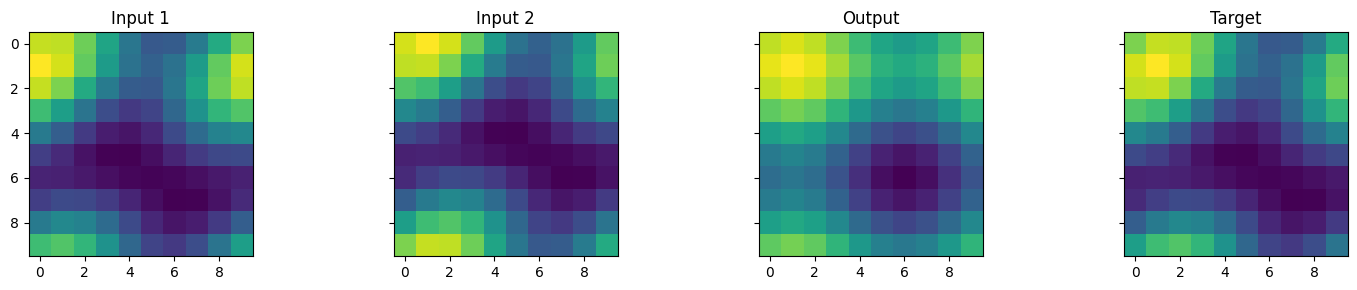

Epoch 310/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 320/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 330/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 340/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 350/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 360/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 370/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 380/1000, Loss: 0.0002, Accuracy: 100.00%
Epoch 390/1000, Loss: 0.0001, Accuracy: 100.00%
Epoch 400/1000, Loss: 0.0001, Accuracy: 95.42%
Epoch 400/1000, Loss: 0.000077


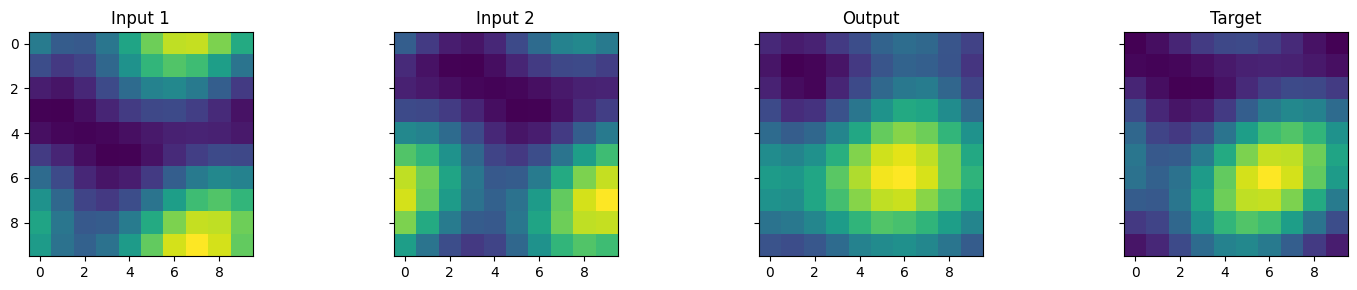

Epoch 410/1000, Loss: 0.0000, Accuracy: 98.17%
Epoch 420/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 430/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 440/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 450/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 460/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 470/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 480/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 490/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 500/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 500/1000, Loss: 0.000000


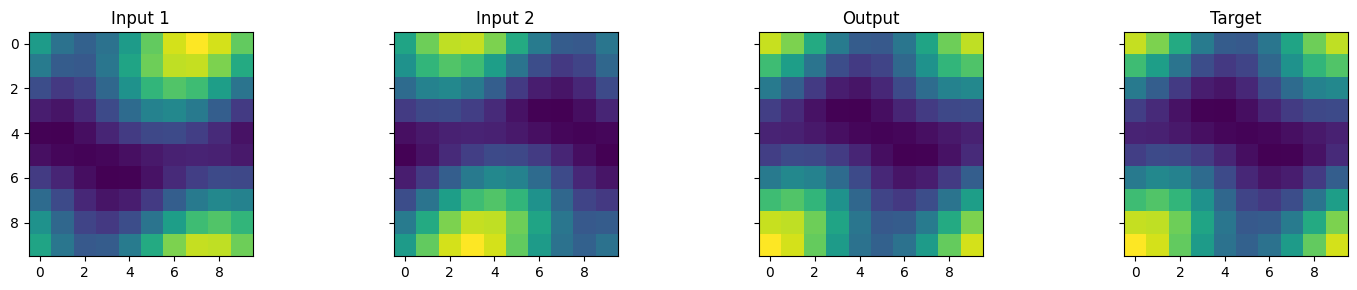

Epoch 510/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 520/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 530/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 540/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 550/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 560/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 570/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 580/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 590/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 600/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 600/1000, Loss: 0.000000


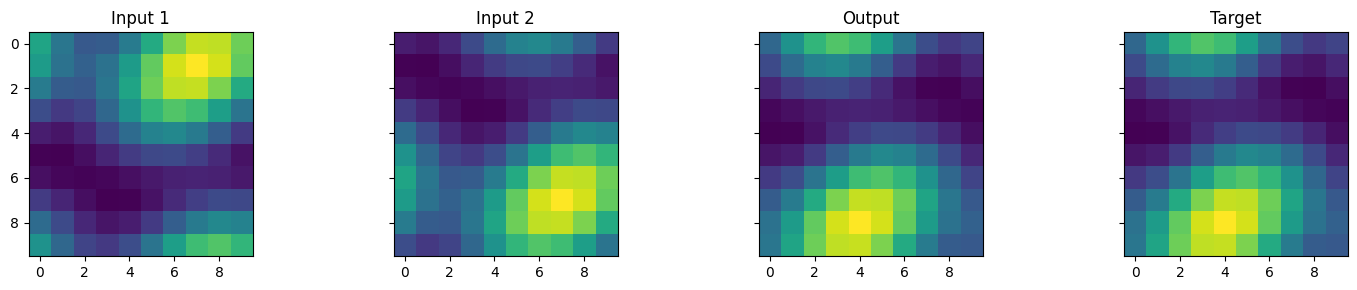

Epoch 610/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 620/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 630/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 640/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 650/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 660/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 670/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 680/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 690/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 700/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 700/1000, Loss: 0.000000


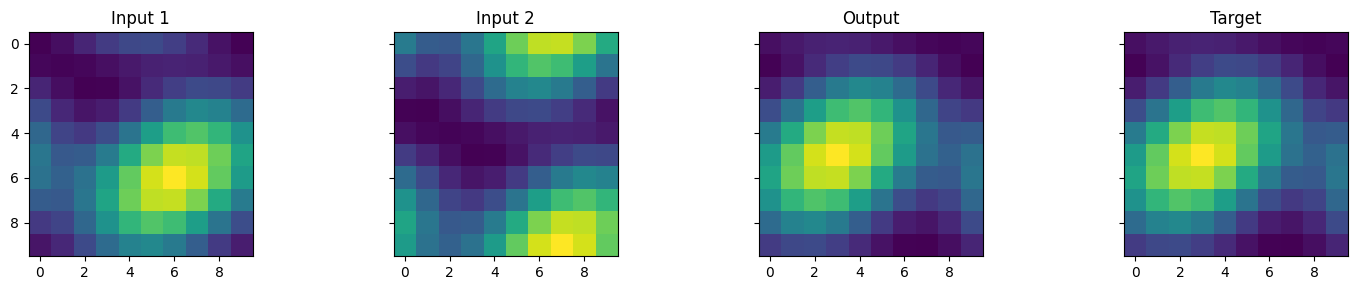

Epoch 710/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 720/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 730/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 740/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 750/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 760/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 770/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 780/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 790/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 800/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 800/1000, Loss: 0.000000


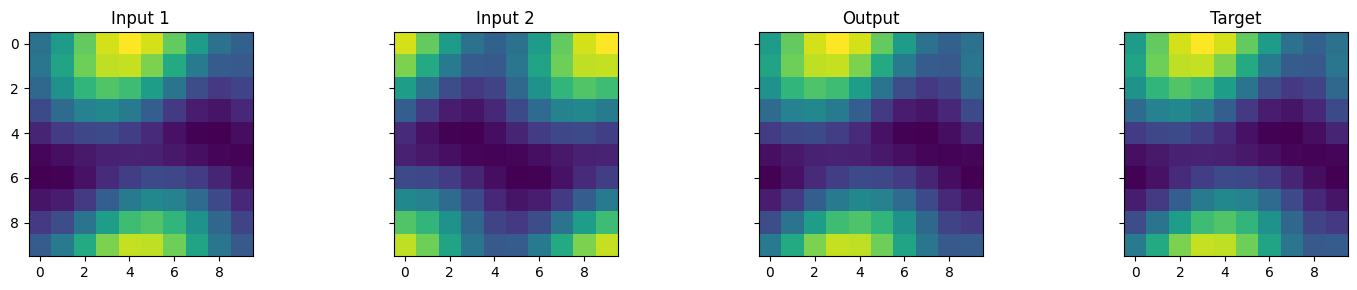

Epoch 810/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 820/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 830/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 840/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 850/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 860/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 870/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 880/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 890/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 900/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 900/1000, Loss: 0.000000


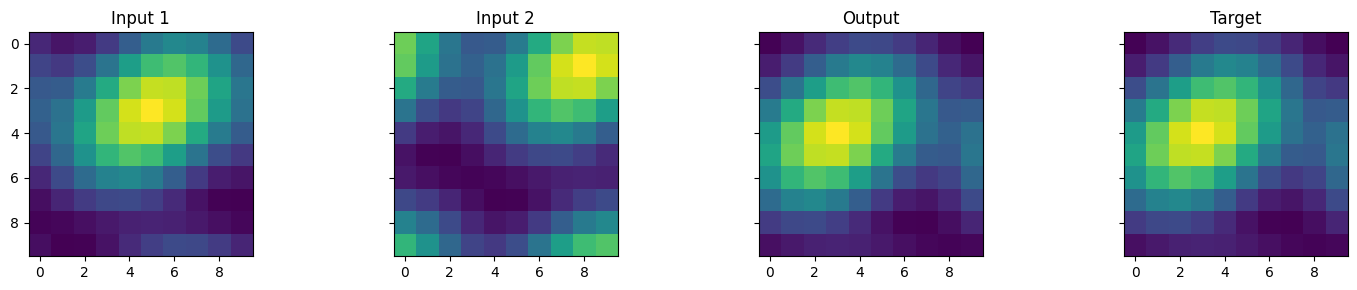

Epoch 910/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 920/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 930/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 940/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 950/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 960/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 970/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 980/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 990/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 1000/1000, Loss: 0.0000, Accuracy: 100.00%
Epoch 1000/1000, Loss: 0.000000


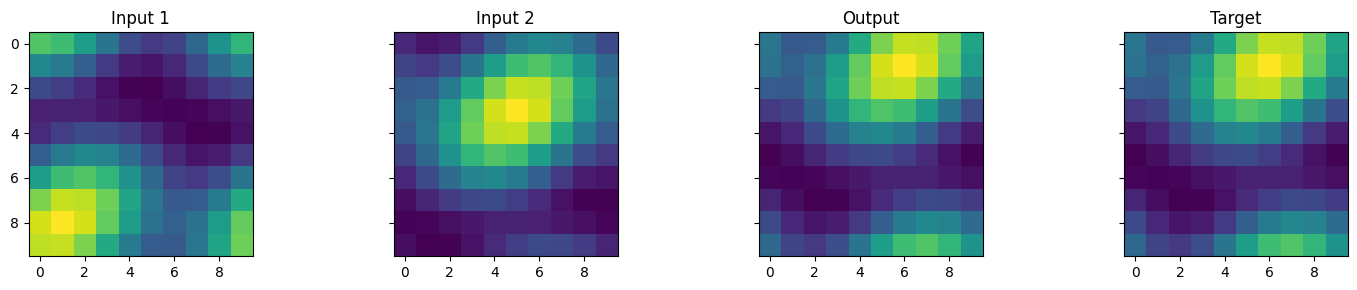

In [83]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

seed = 0#0  # or any integer you like
#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Initialize model
hidden_size = 6 * 16 
model = TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=1e-2, output_scale=1e0)
model = model.to(device)

# Check if tensors and model are on the correct device (cuda or cpu)
print(f"X_tensor device: {X_tensor.device}")
print(f"Y_tensor device: {Y_tensor.device}")
print(f"Model device: {next(model.parameters()).device}")

# Create loss function
loss = nn.MSELoss()


# Construct optimizer
lr, mom = 0.01, 0.9
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom) # TODO: try adam optimizer.
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Train the model
epochs = 1000#001
loss_history, accuracy_history, param_history = train(model, dataloader, loss, optimizer, epochs=epochs, verbose_interval=10)

In [84]:
import pickle

with open("training_history.pkl", "wb") as f:
    pickle.dump({
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
        "param_history": param_history
    }, f)

print("Training history saved to training_history.pkl. You can reload it later with pickle.load(open('training_history.pkl', 'rb')).")



Training history saved to training_history.pkl. You can reload it later with pickle.load(open('training_history.pkl', 'rb')).


## Plot Loss

[[3.08148791e-35 3.38000000e-02 2.15653922e-35 1.92807081e-35
  9.38324448e-34 1.39148438e-34]
 [4.00000000e-02 2.00000000e-02 3.79370669e-36 3.26165186e-35
  3.72499330e-35 5.82593808e-35]
 [3.08148791e-35 1.23917183e-34 2.35690376e-35 3.20156624e-36
  6.30049121e-36 2.49234267e-35]
 [0.00000000e+00 1.48986200e-34 1.51262802e-35 3.70014826e-36
  1.04700826e-35 5.82593808e-35]
 [3.08148791e-35 2.20557395e-35 2.61172248e-36 2.49974327e-35
  2.32809051e-35 2.70766818e-35]
 [4.81482486e-37 1.05065557e-34 1.56338719e-35 3.16802685e-35
  6.20520457e-35 4.81482486e-37]
 [3.08148791e-35 1.21169974e-34 3.03832793e-35 9.01217995e-35
  1.12060586e-36 2.70766818e-35]
 [4.81482486e-37 1.03327776e-34 2.11094063e-35 6.69878771e-35
  1.80797310e-34 5.82593808e-35]
 [3.08148791e-35 2.21603655e-35 2.22749411e-35 3.12454906e-35
  7.30598574e-36 2.49234267e-35]
 [4.00000000e-02 2.44472042e-34 4.09832567e-35 3.61533509e-36
  4.70820406e-35 5.82593808e-35]]
[ 0.   0.1  0.2  0.3  0.4 -0.5 -0.4 -0.3 -0.2 -0.

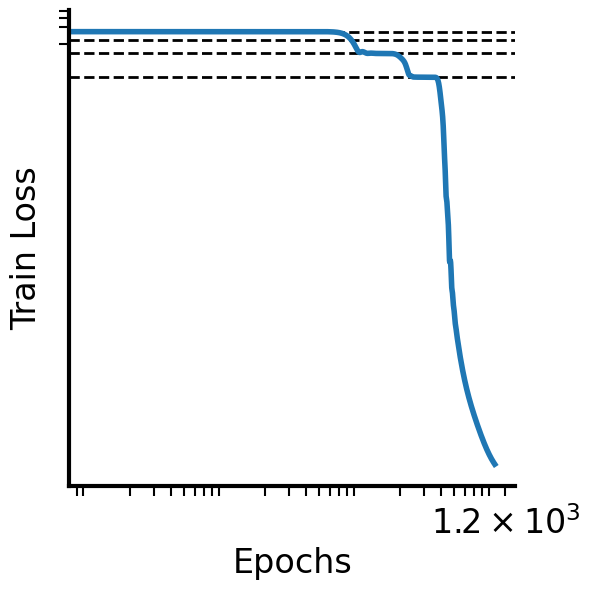

In [85]:
# Does not need to be changed from 1D case

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(list(loss_history), lw=4)


# === Compute power spectrum of template ===
p = int(np.sqrt(len(template)))
x_freq, y_freq, power = get_power_2d(template.reshape((p, p)))
print(power)
print(x_freq)
print(y_freq)
power = power.flatten()

valid = power > 1e-20
power = power[valid]
sorted_idx = np.argsort(-power)
power = power[sorted_idx]

# Plot theoretical lines
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / (p * p)
for k, alpha in enumerate(alpha_values):
    ax.axhline(y=coef * alpha, color='black', linestyle='--', linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(1e-2, 1e0)

ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)

style_axes(ax)
plt.grid(False)
plt.tight_layout()
plt.savefig("loss-without-lines.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum of output

In [71]:
# Does not need to be changed from 1D case
# === SETTINGS ===
p = Y_tensor.shape[1] # will actually be p*p for 2D modsum, but this is fine.
num_freqs = p // 2 + 1

# Compute template power spectrum
template_ft = np.fft.rfft(template)
template_power = np.abs(template_ft)[:num_freqs]

# === Compute power spectrum of template ===
freq, power = get_power_2d(template.reshape((int(np.sqrt(p)), int(np.sqrt(p)))))
valid = power > 1e-20
freq, power = freq[valid], power[valid]
sorted_idx = np.argsort(-power)
freq, power = freq[sorted_idx], power[sorted_idx]

# === Theory lines ===
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / p
theta0 = np.sqrt(2) * model.init_scale
uMax = [np.sqrt(2 * p / 27) * (p * power[k] / 2)**(3/2) / p**2 for k in range(len(power))]
tau_values = [(1 / theta0 - 1) / (3 * uMax[k]) for k in range(len(uMax))]
step_size = 2 * coef * lr / (1 - mom)


# Color settings
cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]

# Compute output power over time (GD)
num_points = 1000
steps = np.unique(np.logspace(0, np.log10(len(param_history) - 1), num_points, dtype=int))
powers_over_time = []

for step in steps:
    model.load_state_dict(param_history[step])
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        ft = np.fft.rfft(outputs.detach().cpu().numpy(), axis=1)
        avg_power = np.mean(np.abs(ft), axis=0)
        powers_over_time.append(avg_power)

powers_over_time = np.array(powers_over_time)  # shape: (steps, freqs)


# Compute output power over time (AGF)
f = utilmax_lr / (lr/(1-mom))
AGF_steps = results["t"]
powers_over_time_AGF = []
for i, step in enumerate(AGF_steps):
    outputs = results["pred"][i]
    ft = np.fft.rfft(outputs.detach().cpu().numpy(), axis=1)
    avg_power = np.mean(np.abs(ft), axis=0)
    powers_over_time_AGF.append(avg_power)
powers_over_time_AGF = np.array(powers_over_time_AGF)  # shape: (steps, freqs)
AGF_steps = [f * t for t in AGF_steps]

AGF_steps.append(epochs)
powers_over_time_AGF = np.vstack([
    powers_over_time_AGF,
    powers_over_time_AGF[-1, :]
])

# === PLOTTING ===
fig, ax = plt.subplots(figsize=(6, 7))

for k in range(num_freqs):
    color = colors[k]
    label = fr"$\xi = {k}$" if k in [1, 3, 5] else None
    ax.plot(steps, powers_over_time[:, k], color=color, lw=3, label=label)
    label_agf = 'AGF' if k == 10 else None
    ax.step(AGF_steps, powers_over_time_AGF[:, k], color='k', lw=2, ls='dashed', where="post", label=label_agf)
    ax.axhline(template_power[k], color=color, linestyle='dotted', linewidth=2, alpha=0.5, zorder=-10)

for k, tau in enumerate(tau_values):
    color = colors[freq[k]]
    ax.axvline(x=tau / step_size, color=color, linestyle='dashed', linewidth=2, alpha=0.5)

    # Add arrow at intersection
    x = tau / step_size
    y = template_power[freq[k]]
    #draw an arrow from the lower bound to the right
    #use default color cycle
    ax.arrow(1.04 * x, y + 0.5, 1.5 * x, 0, 
             head_width=0.2, head_length=x*0.2, length_includes_head=True,
             fc=color, ec=color, lw=4)

# # Add vertical lines if needed
# for step in time_steps:
#     ax.axvline(x=step, color='gray', alpha=0.5, linestyle='solid', linewidth=2)

# Labeling and formatting
ax.set_xscale('log')
ax.set_xlim(5e1, 2e6)
ax.set_xticks([1000, 10000, 100000, epochs-1])
ax.set_ylabel("Power", fontsize=24)
ax.set_xlabel("Epochs", fontsize=24)
ax.legend(fontsize=14, title="Frequency", title_fontsize=16, loc='upper right', bbox_to_anchor=(1, 0.9), labelspacing=0.25)

style_axes(ax)
ax.set_xticks([1000, 10000, 100000, epochs-1])
ax.grid(False)
plt.tight_layout()
plt.savefig("fourier_power_only.pdf", bbox_inches="tight")
plt.show()

ValueError: too many values to unpack (expected 2)

## Plot outputs
TODO: un-flatten predicted signals. First column is ground truth, second column is predicted signal, third column is MSE between them.

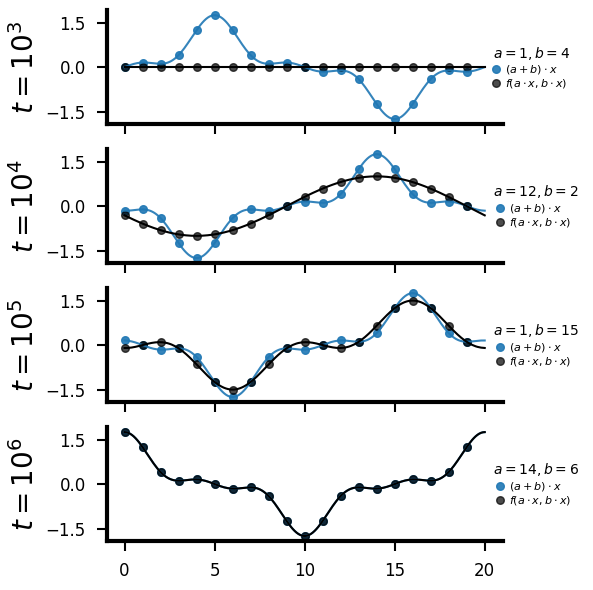

In [ ]:
import matplotlib.pyplot as plt

# Choose time steps to visualize
steps_to_show = [1000, 10000, 100000, epochs-1]
num_samples = 1  # how many examples to plot per row
p = Y_tensor.shape[1] # will actually be p*p for 2D modsum, but this is fine.
x = np.arange(p)

fig, axes = plt.subplots(len(steps_to_show), 1, figsize=(6, 6), sharex=True)

for row, step in enumerate(steps_to_show):
    # Load weights at this step
    model.load_state_dict(param_history[step])
    model.eval()

    indices = np.random.choice(len(Y_tensor), size=num_samples, replace=False)
    with torch.no_grad():
        preds = model(X_tensor[indices]).detach().cpu().numpy()
        truths = Y_tensor[indices].detach().cpu().numpy()

    ax = axes[row]
    for i, idx in enumerate(indices):
        a = idx // p
        b = idx % p
        label_true = r"$(a + b) \cdot x$"
        label_pred = r"$f(a \cdot x, b \cdot x)$"

        # Plot ground truth
        plot2D(ax, truths[i], color=f"C{i}", alpha=0.9, continuous=True)

        # Plot prediction
        plot2D(ax, preds[i], color='k', alpha=1.0, continuous=True)

    style_axes(ax, numyticks=3, labelsize=12)
    ax.grid(False)
    ax.set_ylabel(fr"$t = 10^{{{int(np.log10(step))}}}$", fontsize=20)

    # Only bottom row gets x-ticks
    if row < len(steps_to_show) - 1:
        ax.tick_params(labelbottom=False)

    # ax.legend(loc='best', fontsize=12, title=fr"$a = {a}, b = {b}$", handlelength=0, labelspacing=0.1, title_fontsize=14, frameon=False)
    ax.legend(
        loc='center left',
        bbox_to_anchor=(0.95, 0.5),  # X slightly beyond the right edge, Y centered
        fontsize=8,
        title=fr"$a = {a}, b = {b}$",
        title_fontsize=10,
        handlelength=0,
        labelspacing=0.1,
        frameon=False
    )

# axes[-1].set_xlabel("Output Index", fontsize=20)
plt.tight_layout()
plt.savefig("predictions.pdf", bbox_inches='tight')

## Plot Weights
TODO: un-flatten the weights, frequencies and phases can stay in vector I think.

/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/4254458089.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/4254458089.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/Users/danielkunin/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


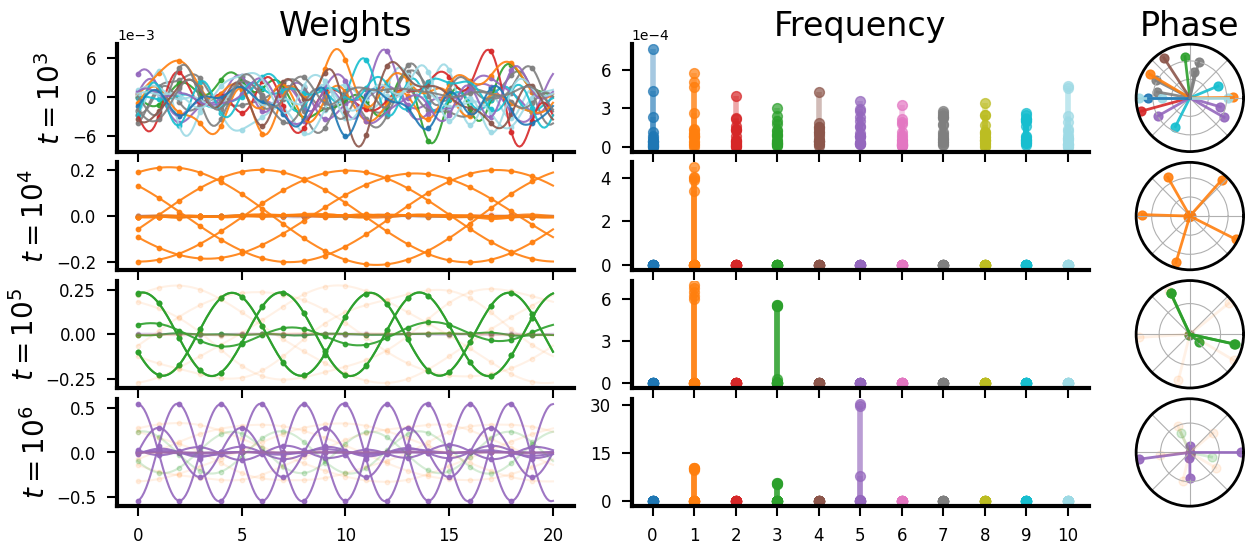

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

# Steps and corresponding highlighted frequencies

steps = [1000, 10000, 100000, epochs-1]
highlight_freqs_list = [[], [1], [3], [5]]

num_rows, num_cols = len(steps), 3

# Use gridspec to control layout
fig = plt.figure(figsize=(24, 6), constrained_layout=True)
gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1.1, 1.1, 2.0], wspace=0.1, hspace=0.1)
axes = np.empty((num_rows, num_cols), dtype=object)

# Create axes
for row in range(num_rows):
    for col in range(num_cols):
        if col == 2:
            ax = fig.add_subplot(gs[row, col], projection='polar')
        else:
            ax = fig.add_subplot(gs[row, col])  # ⬅ no sharex anymore
        axes[row, col] = ax

num_freqs = None
for row, index in enumerate(steps):
    highlight_freqs = highlight_freqs_list[row]
    params = param_history[index]
    W = params['W'].numpy()
    h, p = W.shape

    if num_freqs is None:
        num_freqs = p // 2 + 1
        cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
        colors = [cmap(i) for i in range(num_freqs)]
        manual_colors = {
            0: 'tab:blue',
            1: 'tab:orange',
            2: 'tab:red',
            3: 'tab:green',
            4: 'tab:brown',
            5: 'tab:purple',
        }
        freq_colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]


    # === Column 1: Weights ===
    ax = axes[row, 0]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        x = np.linspace(0, p - 1, 500)
        plot2D(ax, w, color=color, continuous=True, alpha=alpha)
        # ax.scatter(np.arange(p), w, color=color, s=10, alpha=alpha)
    if row == 0: ax.set_title("Weights", fontsize=24)
    ax.set_ylabel(fr"$t = 10^{{{int(np.log10(index))}}}$", fontsize=20)
    style_axes(ax, numyticks=3, numxticks=5, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 2: Frequency Spectrum ===
    ax = axes[row, 1]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        for k in range(len(power)):
            color = freq_colors[k]
            ax.vlines(k, 0, power[k], linewidth=4, color=color, alpha=0.4)
            ax.scatter(k, power[k], color=color, s=50, alpha=0.7)
    # ax.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.4)
    ax.set_xlim(-0.5, len(power) - 0.5)
    ax.set_xticks(np.arange(len(power)))
    if row == 0: ax.set_title("Frequency", fontsize=24)
    style_axes(ax, numyticks=3, numxticks=11, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 3: Phase Polar Plot ===
    ax = axes[row, 2]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        phase = np.angle(ft[dom_idx])
        norm = np.linalg.norm(w)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        ax.plot([phase, phase], [0, norm], color=color, linewidth=2, alpha=alpha)
        ax.scatter(phase, norm, color=color, s=40, alpha=alpha)
        angles = np.arange(0, 360, 45)
        # ax.set_thetagrids(angles, [f"{a}°" if a in [45,135,225,315] else "" for a in angles])
        ax.set_thetagrids(angles, ["" for a in angles])
        ax.set_yticklabels([])
        ax.spines['polar'].set_linewidth(2)
    if row == 0: ax.set_title("Phase", fontsize=24)

# Shift polar plots left to reduce whitespace
for row in range(num_rows):
    ax = axes[row, 2]
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.155, pos.y0, pos.width, pos.height])

plt.savefig("W-weights.pdf", bbox_inches='tight')